In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
import glob
import time
from collections import deque
% matplotlib inline

### Feature Functions

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Feature functions 2

In [3]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    #print(svc.decision_function(heatmap))
    #heatmap[svc.decision_function(heatmap) < threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return window_list
#draw_img,
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Feature functions 3

In [4]:
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

## Vehicle Detection

### Histogram of Oriented Gradients (HOG)

This contains functions for feature extraction of images. The function responsible for HOG features extraction is get_hog_features().

To test this function, I read in test images 

In [5]:
test_images = glob.glob('test_images/*.jpg')

### Test Images

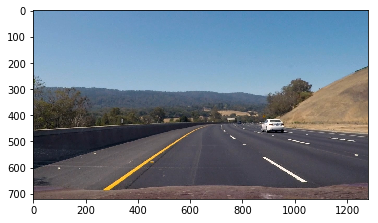

In [6]:
sample_test_image = mpimg.imread(test_images[4])
fig = plt.figure()
plt.imshow(sample_test_image)
plt.show()

Then I read in the ```vehicle``` and ```non-vehicle``` images (Training images).

The Training Images are:
    <ul>
        <li>Vehicle images count: 8792</li>
        <li>Non Vehicle images count: 8968</li>
    <ul>

In [7]:
cars = []
notcars = []
car_images = glob.glob('vehicles/*/*.png')
for image in car_images:
    cars.append(image)

non_car_images = glob.glob('non-vehicles/*/*.png')
for image in non_car_images:
    notcars.append(image)

Here's an example of these images

8792
8968


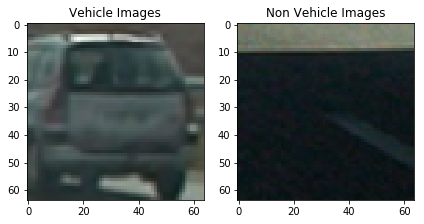

In [8]:
print(len(cars))
print(len(notcars))

fig = plt.figure()
plt.subplot(121)
plt.imshow(mpimg.imread(cars[0]))
plt.title('Vehicle Images')
plt.subplot(122)
plt.imshow(mpimg.imread(notcars[0]))
plt.title('Non Vehicle Images')
fig.tight_layout()

I then explored different color spaces and ``HOG`` parameters (orientation, pixels_per_cell, cells_per_block) and testing using the sample test image.


### 2. Defining HOG parameters.

The parameters were gotten by changing and experimenting to maximize accuracy and minimize fit time.

The final paremeters are:

<table>
    <thead>
        <tr>
            <th>Parameter</th>
            <th>Value</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Color Space</td>
            <td>YCrCb</td>
        </tr>
        <tr>
            <td>HOG orientations</td>
            <td>9</td>
        </tr>
        <tr>
            <td>HOG pixels per cell</td>
            <td>8</td>
        </tr>
        <tr>
            <td>HOG cells per block</td>
            <td>4</td>
        </tr>
        <tr>
            <td>hog_channel</td>
            <td>All</td>
        </tr>
        <tr>
            <td>Spatial binning dimensions</td>
            <td>(32, 32)</td>
        </tr>
        <tr>
            <td>Number of histogram bins</td>
            <td>32</td>
        </tr>
        <tr>
            <td>Spatial features on or off</td>
            <td>On</td>
        </tr>
        <tr>
            <td>Histogram features on or off</td>
            <td>On</td>
        </tr>
        <tr>
            <td>HOG features on or off</td>
            <td>On</td>
        </tr>
    </tbody>
</table>

In [9]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 600] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

### 3. Training a classifier using the selected HOG features and color features.

A linear SVM was used to classify this specific project. using the color soace ``YCrCb`` along with the `HOG features` features, `Spartial features` and `Color histograms`. Accuracy of the classifier was 98.57%, the train and test sets containing 80% and 20% respectively.

In [10]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 13968
55.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9845


With these parameters, I had 98.79% accuracy and trained in 50.57 seconds

In [11]:
svc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [12]:
# Cs = np.logspace(-6, -1, 10)
# tol_list=[0.0001,0.00001]

# clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs,tol=tol_list))

In [13]:
# clf.fit(X_train, y_train)
# clf.best_score_

In [14]:
# clf.best_estimator_

In [15]:
# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC(C=0.0001668100537200059,tol=0.0001)
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()

### Sliding Window Search


A sliding window method is used, while performing our classification on each window. Initial result is shown below

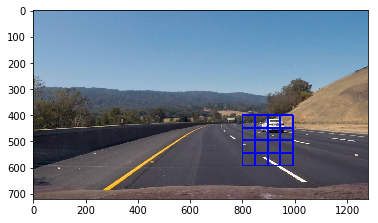

In [16]:
draw_image = np.copy(sample_test_image)
windows = slide_window(sample_test_image, x_start_stop=[800, 1000], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(sample_test_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(sample_test_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

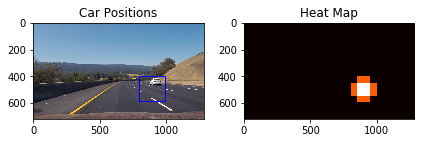

In [17]:
heat = np.zeros_like(sample_test_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
        
draw_img = draw_labeled_bboxes(np.copy(sample_test_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [37]:
def display_heatmap_test_images(test_image):
    ystart = 400
    ystop = 600
    xstart = 0
    xstop = 1280
    scales = [1,1.3,1.5,1.8,2,2.4,3]
    window_list = []
    for scale in scales:
        window_list += find_cars(test_image, ystart, ystop,xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float) 
    # Add heat to each box in box list
    #heat = add_heat(heat,window_list)
    heatmaps = deque(maxlen = 20)
    # Add heat to each box in box list
    heat = add_heat(heat,window_list)
    
    
    heatmaps.append(heat)
    combined = sum(heatmaps)
    heat = apply_threshold(combined, 2)

    # Apply threshold to help remove false positives
#     heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

### Sliding windows search 2

To capture vechiles of different sizes, different scales of rectangles must be applied, a car may be bigger near the camera but smaller as it passes away
Also we make use of heatmaps to remove false positives

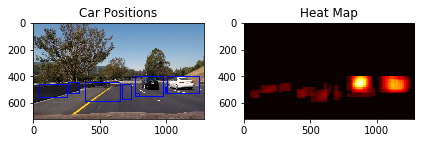

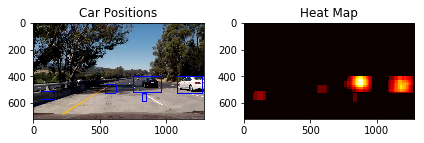

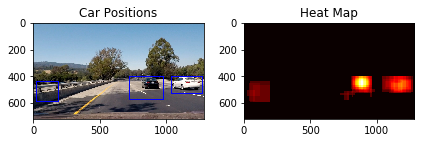

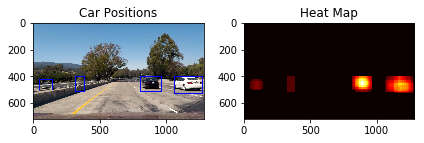

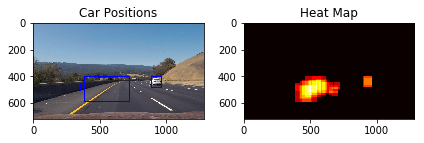

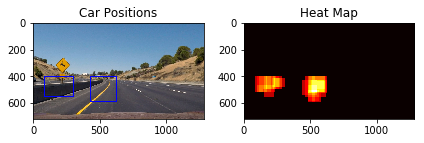

In [38]:
for image in test_images:
    test_image = mpimg.imread(image)
    display_heatmap_test_images(test_image)

### Video Implementation

A pipeline is created from all I have done so far and the final image saved in `project_video_result.mp4`

In [39]:

def process_image(image):
    ystart = 400
    ystop = 600
    xstart = 0
    xstop = 1280
    scales = [1,1.3,1.5,1.8,2,2.4,3]
    window_list = []
    for scale in scales:
        window_list += find_cars(image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmaps = deque(maxlen = 20)
    # Add heat to each box in box list
    heat = add_heat(heat,window_list)
    
    
    heatmaps.append(heat)
    combined = sum(heatmaps)
    heat = apply_threshold(combined, 2)

    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

#     fig = plt.figure()
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
    return draw_img

In [42]:
def create_video():
    vid_output = 'project_video_result.mp4'
    project_video = VideoFileClip('project_video.mp4')
    result_video = project_video.fl_image(process_image)
    result_video.write_videofile(vid_output, audio=False)

In [46]:
create_video()

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:02<59:16,  2.82s/it]


  0%|          | 2/1261 [00:05<57:32,  2.74s/it]


  0%|          | 3/1261 [00:08<59:20,  2.83s/it]


  0%|          | 4/1261 [00:11<57:47,  2.76s/it]


  0%|          | 5/1261 [00:13<56:54,  2.72s/it]


  0%|          | 6/1261 [00:16<55:53,  2.67s/it]


  1%|          | 7/1261 [00:18<55:10,  2.64s/it]


  1%|          | 8/1261 [00:20<54:33,  2.61s/it]


  1%|          | 9/1261 [00:23<53:58,  2.59s/it]


  1%|          | 10/1261 [00:25<53:30,  2.57s/it]


  1%|          | 11/1261 [00:28<53:10,  2.55s/it]


  1%|          | 12/1261 [00:30<52:54,  2.54s/it]


  1%|          | 13/1261 [00:32<52:42,  2.53s/it]


  1%|          | 14/1261 [00:35<52:29,  2.53s/it]


  1%|          | 15/1261 [00:37<52:19,  2.52s/it]


  1%|▏         | 16/1261 [00:40<52:08,  2.51s/it]


  1%|▏         | 17/1261 [00:42<52:08,  2.51s/it]


  1%|▏         | 18/1261 [00:45<52:09,  2.52s/it]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [05:29<46:09,  2.46s/it]


 11%|█         | 135/1261 [05:31<46:06,  2.46s/it]


 11%|█         | 136/1261 [05:34<46:03,  2.46s/it]


 11%|█         | 137/1261 [05:36<46:00,  2.46s/it]


 11%|█         | 138/1261 [05:38<45:57,  2.46s/it]


 11%|█         | 139/1261 [05:41<45:54,  2.45s/it]


 11%|█         | 140/1261 [05:43<45:51,  2.45s/it]


 11%|█         | 141/1261 [05:46<45:48,  2.45s/it]


 11%|█▏        | 142/1261 [05:48<45:45,  2.45s/it]


 11%|█▏        | 143/1261 [05:50<45:42,  2.45s/it]


 11%|█▏        | 144/1261 [05:53<45:39,  2.45s/it]


 11%|█▏        | 145/1261 [05:55<45:37,  2.45s/it]


 12%|█▏        | 146/1261 [05:58<45:34,  2.45s/it]


 12%|█▏        | 147/1261 [06:00<45:31,  2.45s/it]


 12%|█▏        | 148/1261 [06:02<45:28,  2.45s/it]


 12%|█▏        | 149/1261 [06:05<45:25,  2.45s/it]


 12%|█▏        | 150/1261 [06:07<45:22,  2.45s/it]


 12%|█▏        | 151/1261 [06:09<45:19,  2.45s/it]


 12%|█▏        | 152/1261 [06:12<45:16,  2.45s

 21%|██        | 266/1261 [10:44<40:09,  2.42s/it]


 21%|██        | 267/1261 [10:46<40:06,  2.42s/it]


 21%|██▏       | 268/1261 [10:48<40:04,  2.42s/it]


 21%|██▏       | 269/1261 [10:51<40:01,  2.42s/it]


 21%|██▏       | 270/1261 [10:53<39:58,  2.42s/it]


 21%|██▏       | 271/1261 [10:56<39:56,  2.42s/it]


 22%|██▏       | 272/1261 [10:58<39:54,  2.42s/it]


 22%|██▏       | 273/1261 [11:00<39:51,  2.42s/it]


 22%|██▏       | 274/1261 [11:03<39:48,  2.42s/it]


 22%|██▏       | 275/1261 [11:05<39:46,  2.42s/it]


 22%|██▏       | 276/1261 [11:07<39:43,  2.42s/it]


 22%|██▏       | 277/1261 [11:10<39:41,  2.42s/it]


 22%|██▏       | 278/1261 [11:12<39:38,  2.42s/it]


 22%|██▏       | 279/1261 [11:15<39:36,  2.42s/it]


 22%|██▏       | 280/1261 [11:17<39:33,  2.42s/it]


 22%|██▏       | 281/1261 [11:19<39:31,  2.42s/it]


 22%|██▏       | 282/1261 [11:22<39:28,  2.42s/it]


 22%|██▏       | 283/1261 [11:24<39:26,  2.42s/it]


 23%|██▎       | 284/1261 [11:27<39:23,  2.42s

 31%|███▏      | 396/1261 [33:20<1:12:50,  5.05s/it]


 31%|███▏      | 397/1261 [33:23<1:12:39,  5.05s/it]


 32%|███▏      | 398/1261 [33:25<1:12:28,  5.04s/it]


 32%|███▏      | 399/1261 [33:28<1:12:18,  5.03s/it]


 32%|███▏      | 400/1261 [33:30<1:12:07,  5.03s/it]


 32%|███▏      | 401/1261 [33:32<1:11:56,  5.02s/it]


 32%|███▏      | 402/1261 [33:35<1:11:45,  5.01s/it]


 32%|███▏      | 403/1261 [33:37<1:11:35,  5.01s/it]


 32%|███▏      | 404/1261 [33:40<1:11:25,  5.00s/it]


 32%|███▏      | 405/1261 [33:42<1:11:15,  5.00s/it]


 32%|███▏      | 406/1261 [33:45<1:11:05,  4.99s/it]


 32%|███▏      | 407/1261 [33:48<1:10:55,  4.98s/it]


 32%|███▏      | 408/1261 [33:50<1:10:45,  4.98s/it]


 32%|███▏      | 409/1261 [33:53<1:10:35,  4.97s/it]


 33%|███▎      | 410/1261 [33:55<1:10:25,  4.97s/it]


 33%|███▎      | 411/1261 [33:58<1:10:15,  4.96s/it]


 33%|███▎      | 412/1261 [34:00<1:10:05,  4.95s/it]


 33%|███▎      | 413/1261 [34:03<1:09:55,  4.95s/it]


 33%|███▎ 

 42%|████▏     | 525/1261 [38:54<54:33,  4.45s/it]


 42%|████▏     | 526/1261 [38:57<54:26,  4.44s/it]


 42%|████▏     | 527/1261 [39:00<54:19,  4.44s/it]


 42%|████▏     | 528/1261 [39:02<54:12,  4.44s/it]


 42%|████▏     | 529/1261 [39:05<54:05,  4.43s/it]


 42%|████▏     | 530/1261 [39:08<53:58,  4.43s/it]


 42%|████▏     | 531/1261 [39:10<53:51,  4.43s/it]


 42%|████▏     | 532/1261 [39:13<53:44,  4.42s/it]


 42%|████▏     | 533/1261 [39:15<53:37,  4.42s/it]


 42%|████▏     | 534/1261 [39:18<53:30,  4.42s/it]


 42%|████▏     | 535/1261 [39:20<53:23,  4.41s/it]


 43%|████▎     | 536/1261 [39:23<53:16,  4.41s/it]


 43%|████▎     | 537/1261 [39:25<53:09,  4.41s/it]


 43%|████▎     | 538/1261 [39:28<53:02,  4.40s/it]


 43%|████▎     | 539/1261 [39:31<52:56,  4.40s/it]


 43%|████▎     | 540/1261 [39:34<52:49,  4.40s/it]


 43%|████▎     | 541/1261 [39:36<52:42,  4.39s/it]


 43%|████▎     | 542/1261 [39:39<52:35,  4.39s/it]


 43%|████▎     | 543/1261 [39:41<52:29,  4.39s

 52%|█████▏    | 657/1261 [44:40<41:04,  4.08s/it]


 52%|█████▏    | 658/1261 [44:42<40:58,  4.08s/it]


 52%|█████▏    | 659/1261 [44:45<40:53,  4.08s/it]


 52%|█████▏    | 660/1261 [44:48<40:48,  4.07s/it]


 52%|█████▏    | 661/1261 [44:51<40:43,  4.07s/it]


 52%|█████▏    | 662/1261 [44:54<40:37,  4.07s/it]


 53%|█████▎    | 663/1261 [44:56<40:32,  4.07s/it]


 53%|█████▎    | 664/1261 [44:59<40:26,  4.07s/it]


 53%|█████▎    | 665/1261 [45:02<40:21,  4.06s/it]


 53%|█████▎    | 666/1261 [45:05<40:16,  4.06s/it]


 53%|█████▎    | 667/1261 [45:07<40:11,  4.06s/it]


 53%|█████▎    | 668/1261 [45:10<40:06,  4.06s/it]


 53%|█████▎    | 669/1261 [45:13<40:00,  4.06s/it]


 53%|█████▎    | 670/1261 [45:15<39:55,  4.05s/it]


 53%|█████▎    | 671/1261 [45:18<39:50,  4.05s/it]


 53%|█████▎    | 672/1261 [45:21<39:44,  4.05s/it]


 53%|█████▎    | 673/1261 [45:23<39:39,  4.05s/it]


 53%|█████▎    | 674/1261 [45:26<39:34,  4.05s/it]


 54%|█████▎    | 675/1261 [45:29<39:29,  4.04s

 63%|██████▎   | 789/1261 [50:37<30:16,  3.85s/it]


 63%|██████▎   | 790/1261 [50:39<30:12,  3.85s/it]


 63%|██████▎   | 791/1261 [50:42<30:07,  3.85s/it]


 63%|██████▎   | 792/1261 [50:44<30:03,  3.84s/it]


 63%|██████▎   | 793/1261 [50:47<29:58,  3.84s/it]


 63%|██████▎   | 794/1261 [50:49<29:53,  3.84s/it]


 63%|██████▎   | 795/1261 [50:52<29:49,  3.84s/it]


 63%|██████▎   | 796/1261 [50:55<29:44,  3.84s/it]


 63%|██████▎   | 797/1261 [50:58<29:40,  3.84s/it]


 63%|██████▎   | 798/1261 [51:01<29:36,  3.84s/it]


 63%|██████▎   | 799/1261 [51:03<29:31,  3.83s/it]


 63%|██████▎   | 800/1261 [51:06<29:27,  3.83s/it]


 64%|██████▎   | 801/1261 [51:09<29:22,  3.83s/it]


 64%|██████▎   | 802/1261 [51:11<29:18,  3.83s/it]


 64%|██████▎   | 803/1261 [51:14<29:13,  3.83s/it]


 64%|██████▍   | 804/1261 [51:17<29:09,  3.83s/it]


 64%|██████▍   | 805/1261 [51:19<29:04,  3.83s/it]


 64%|██████▍   | 806/1261 [51:22<29:00,  3.82s/it]


 64%|██████▍   | 807/1261 [51:25<28:55,  3.82s

 73%|███████▎  | 921/1261 [56:15<20:46,  3.67s/it]


 73%|███████▎  | 922/1261 [56:18<20:42,  3.66s/it]


 73%|███████▎  | 923/1261 [56:20<20:38,  3.66s/it]


 73%|███████▎  | 924/1261 [56:23<20:33,  3.66s/it]


 73%|███████▎  | 925/1261 [56:25<20:29,  3.66s/it]


 73%|███████▎  | 926/1261 [56:28<20:25,  3.66s/it]


 74%|███████▎  | 927/1261 [56:30<20:21,  3.66s/it]


 74%|███████▎  | 928/1261 [56:33<20:17,  3.66s/it]


 74%|███████▎  | 929/1261 [56:35<20:13,  3.66s/it]


 74%|███████▍  | 930/1261 [56:38<20:09,  3.65s/it]


 74%|███████▍  | 931/1261 [56:40<20:05,  3.65s/it]


 74%|███████▍  | 932/1261 [56:42<20:01,  3.65s/it]


 74%|███████▍  | 933/1261 [56:45<19:57,  3.65s/it]


 74%|███████▍  | 934/1261 [56:47<19:53,  3.65s/it]


 74%|███████▍  | 935/1261 [56:50<19:49,  3.65s/it]


 74%|███████▍  | 936/1261 [56:52<19:45,  3.65s/it]


 74%|███████▍  | 937/1261 [56:55<19:40,  3.64s/it]


 74%|███████▍  | 938/1261 [56:57<19:36,  3.64s/it]


 74%|███████▍  | 939/1261 [57:00<19:32,  3.64s

 83%|████████▎ | 1051/1261 [1:01:38<12:18,  3.52s/it]


 83%|████████▎ | 1052/1261 [1:01:40<12:15,  3.52s/it]


 84%|████████▎ | 1053/1261 [1:01:43<12:11,  3.52s/it]


 84%|████████▎ | 1054/1261 [1:01:45<12:07,  3.52s/it]


 84%|████████▎ | 1055/1261 [1:01:48<12:04,  3.51s/it]


 84%|████████▎ | 1056/1261 [1:01:50<12:00,  3.51s/it]


 84%|████████▍ | 1057/1261 [1:01:53<11:56,  3.51s/it]


 84%|████████▍ | 1058/1261 [1:01:55<11:52,  3.51s/it]


 84%|████████▍ | 1059/1261 [1:01:58<11:49,  3.51s/it]


 84%|████████▍ | 1060/1261 [1:02:00<11:45,  3.51s/it]


 84%|████████▍ | 1061/1261 [1:02:03<11:41,  3.51s/it]


 84%|████████▍ | 1062/1261 [1:02:05<11:38,  3.51s/it]


 84%|████████▍ | 1063/1261 [1:02:08<11:34,  3.51s/it]


 84%|████████▍ | 1064/1261 [1:02:10<11:30,  3.51s/it]


 84%|████████▍ | 1065/1261 [1:02:12<11:27,  3.51s/it]


 85%|████████▍ | 1066/1261 [1:02:15<11:23,  3.50s/it]


 85%|████████▍ | 1067/1261 [1:02:17<11:19,  3.50s/it]


 85%|████████▍ | 1068/1261 [1:02:20<11:15,  3.50

 93%|█████████▎| 1177/1261 [1:06:50<04:46,  3.41s/it]


 93%|█████████▎| 1178/1261 [1:06:53<04:42,  3.41s/it]


 93%|█████████▎| 1179/1261 [1:06:55<04:39,  3.41s/it]


 94%|█████████▎| 1180/1261 [1:06:58<04:35,  3.41s/it]


 94%|█████████▎| 1181/1261 [1:07:00<04:32,  3.40s/it]


 94%|█████████▎| 1182/1261 [1:07:03<04:28,  3.40s/it]


 94%|█████████▍| 1183/1261 [1:07:05<04:25,  3.40s/it]


 94%|█████████▍| 1184/1261 [1:07:08<04:21,  3.40s/it]


 94%|█████████▍| 1185/1261 [1:07:10<04:18,  3.40s/it]


 94%|█████████▍| 1186/1261 [1:07:13<04:15,  3.40s/it]


 94%|█████████▍| 1187/1261 [1:07:15<04:11,  3.40s/it]


 94%|█████████▍| 1188/1261 [1:07:18<04:08,  3.40s/it]


 94%|█████████▍| 1189/1261 [1:07:20<04:04,  3.40s/it]


 94%|█████████▍| 1190/1261 [1:07:23<04:01,  3.40s/it]


 94%|█████████▍| 1191/1261 [1:07:25<03:57,  3.40s/it]


 95%|█████████▍| 1192/1261 [1:07:28<03:54,  3.40s/it]


 95%|█████████▍| 1193/1261 [1:07:30<03:50,  3.40s/it]


 95%|█████████▍| 1194/1261 [1:07:33<03:47,  3.39

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 



### 2. Filtering for false positives and smoothing

For each frame, I create a heatmap and then a threshold to identify vehicle positions. Next i use `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap, assuming each blob corresponds to a vehicle. 

Finally i construct bounding boxes to cover the area of each blob detected

## Discussion

#### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

A major improvement would be the problem of when a car is next to the other and are identified as one, 
Also my pipeline is not 100% efficient, there is still much noise from surrounding cars, environment, etc